In [1]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import cv2

In [2]:
def Detection_Using_HSVColorspace(image, x_min, y_min, width, height):
    
    ##getting region of interest
    region_of_interest = image[y_min: y_min+height, x_min:x_min+width]
    
    ##converting region of interest from BGR to HSV Format
    region_of_int_hsv = cv2.cvtColor(region_of_interest, cv2.COLOR_BGR2HSV)
    
    
    ##getting the histogram for hue channel of region of interest in hsv
    histogram_regio_of_int = cv2.calcHist([region_of_int_hsv], [0], None, [180], [0, 180])
    
    
    ##converting the image to hsv format
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    ##creating the mask from the hsv image and region of interest histogram
    hsv_mask = cv2.calcBackProject([image_hsv], [0], histogram_regio_of_int, [0, 180], 1)
    
    ##termination criteria has been set to 10 iterations for mean shift algorithm, 
    ## moving by 1point on the image and mean shift operation is stopped with error 
    ## termed by 'TERM_CRITERIA_EPS'
    
    img_mask = hsv_mask.copy()
    #img_copy = image.copy()
    #plot_window_movement_mask( img_copy, img_mask,x_min, y_min, width, height)
    
    metric_used = (cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT, 10, 1) 
    
    
    ##applying the meanshift with the mask
    ret, detector_win = cv2.meanShift(hsv_mask, (x_min, y_min, width, height),  metric_used)
    
    ##getting the coordinates of the updated bounding box/window
    x, y, w, h = detector_win
    
    cv2.rectangle(image, (x, y), ( x+w, y+h), (0, 0, 255), 3)
    
    return  img_mask, image, x, y, x+w, y+h

In [3]:
import json

In [4]:
train_annotations_dir = 'train_annotations'
    
with open(train_annotations_dir , 'r') as f:
    train_annotations_given = json.load(f)

##### Mean Shift for Image Id: 341

In [5]:
image_directory = 'Penguins vs Turtles/archive/train/train/image_id_341.jpg'
img = cv2.imread(image_directory)
min_x, min_y, width, height = train_annotations_given[341]['bbox']
img_copy = img.copy()
masked_image, bounded_image, x_min, y_min, x_max, y_max = Detection_Using_HSVColorspace(img_copy, min_x, min_y, width, height)
#print(x_min, y_min, width, height)

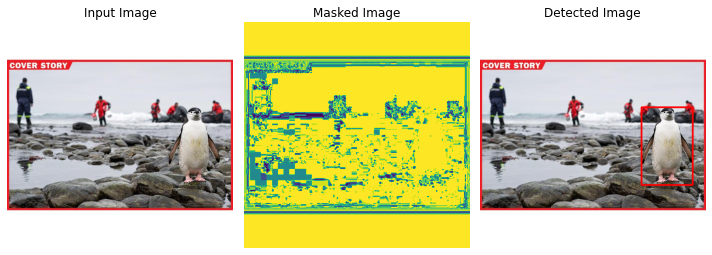

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (10, 4))

# the original image in the first subplot
axes[0].imshow(img[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Input Image')


axes[1].imshow(masked_image)
axes[1].axis('off')
axes[1].set_title('Masked Image')

axes[2].imshow(bounded_image[:,:,::-1])
axes[2].axis('off')
axes[2].set_title('Detected Image')


plt.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()

##### Mean Shift for Image Id: 38

In [7]:
image_directory = 'Penguins vs Turtles/archive/train/train/image_id_038.jpg'
img = cv2.imread(image_directory)
min_x, min_y, width, height = train_annotations_given[38]['bbox']
img_copy = img.copy()
masked_image, bounded_image, x_min, y_min, x_max, y_max = Detection_Using_HSVColorspace(img_copy, min_x, min_y, width, height)
#print(x_min, y_min, width, height)

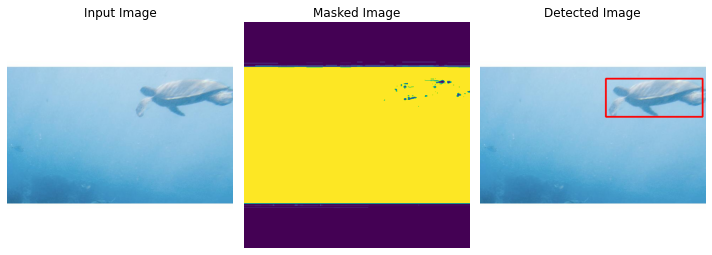

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (10, 4))

# the original image in the first subplot
axes[0].imshow(img[:,:,::-1])
axes[0].axis('off')
axes[0].set_title('Input Image')


axes[1].imshow(masked_image)
axes[1].axis('off')
axes[1].set_title('Masked Image')

axes[2].imshow(bounded_image[:,:,::-1])
axes[2].axis('off')
axes[2].set_title('Detected Image')


plt.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()

##### IOU Detection Visualization on Validation Data Set

In [9]:
def estimate_intersect_area(pred_cords, actual_cords):
    
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_cords
    
    x_min_actual, y_min_actual, x_max_actual, y_max_actual = actual_cords
    
    ##common area in x-axis
    commomn_x_area = max(0, (min(x_max_pred, x_max_actual) - max(x_min_pred,  x_min_actual)))
    
    ##common-area in y-axis
    commomn_y_area = max(0, (min(y_max_pred, y_max_actual) - max(y_min_pred,  y_min_actual)))
    
    ##getting the common area between two images
    intersection_area = commomn_x_area * commomn_y_area

    
    return intersection_area

In [10]:
def estimate_union_area(pred_cords, actual_cords):
    
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_cords
    
    x_min_actual, y_min_actual, x_max_actual, y_max_actual = actual_cords
    
    
    area_pred =  (x_max_pred -  x_min_pred) * (y_max_pred - y_min_pred)
    
    area_actual = (x_max_actual -  x_min_actual) * (y_max_actual - y_min_actual)
    
    area_estimated_union = area_pred + area_actual - estimate_intersect_area(pred_cords, actual_cords)
    
    return area_estimated_union

In [11]:
def estimate_iou_calculate(pred_bbox, actual_bbox):
    
    area_intersected = estimate_intersect_area(pred_bbox, actual_bbox)
    area_union = estimate_union_area(pred_bbox, actual_bbox)
    estimate_iou = area_intersected / area_union
    return estimate_iou

In [12]:
import os
import json
def loading_of_dataset(directory):
    imgs_dir = os.listdir(directory)
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Create a 3x3 subplot grid
    
    ##going through annotations folder in valid directory
    valid_annotations_dir = 'valid_annotations'
    
    ##going through the file and reading loading the contents
    with open(valid_annotations_dir, 'r') as f:
         valid_annotations_given = json.load(f)

    for i, label in enumerate(imgs_dir):
        if i >= 9:
            break  
        
        img_dir = os.path.join(directory, label)  # taking the full image directory
        image = cv2.imread(img_dir)
        img_rgb = image[:,:,::-1]
        
        
        ##Getting particular file data
        x_min, y_min, width, height = valid_annotations_given[i]['bbox']
        
        
        
        masked_img, bounded_image,min_x, min_y, max_x, max_y = Detection_Using_HSVColorspace(image,x_min, y_min, width, height)
        
        ###Getting bounded by actaul bounding box
        cv2.rectangle(bounded_image, (x_min, y_min), ( x_min+width, y_min+height), (0, 255, 0), 3)
        
        iou_score = estimate_iou_calculate([min_x, min_y, max_x, max_y], [x_min, y_min, x_min+width, y_min+height])
        
        cv2.putText(bounded_image, "IoU: {:.4f}".format(iou_score), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        

        row = i // 3
        col = i % 3
        axes[row, col].imshow(bounded_image[:, :, ::-1])  # Convert BGR to RGB for matplotlib
        axes[row, col].set_title(f'Image {i + 1} with IoU: {iou_score:.4f}')
        
        
        axes[row, col].axis('off')
    
    plt.tight_layout() 
    plt.show()

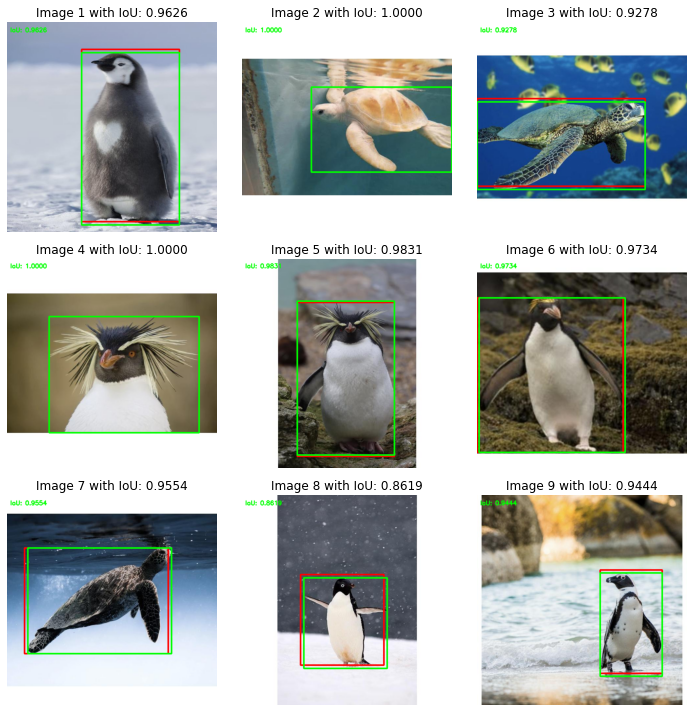

In [13]:
valid_directory = "Penguins vs Turtles/archive/valid/valid"
loading_of_dataset(valid_directory)